In [1]:
 ! pip install tensorflow tensorflow-text==2.8.* 
 ! pip install tf-models-official


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 5.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.4 MB/s 
     |████████████████████████████████| 352 kB 44.3 MB/s 
     |████████████████████████████████| 116 kB 4.2 MB/s 
     |████████████████████████████████| 1.1 MB 11.4 MB/s 
     |████████████████████████████████| 511.8 MB 7.4 kB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 99 kB 7.9 MB/s 
     |████████████████████████████████| 4.6 MB 45.6 MB/s 
     |████████████████████████████████| 1.3 MB 48.8 MB/s 
     |████████████████████████████████| 636 kB 50.7 MB/s 
     |████████████████████████████████| 238 kB 49.9 MB/s 
     |████████████████████████████████| 438 kB 48.6 MB/s 
     |████████████████████████████████| 5.8 MB 40.2 MB

Import packages


In [2]:
import pandas as pd
import numpy as np
import re
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_text as tf_text
import tensorflow_hub as hub
from official.nlp import optimization
import csv
from tensorflow.keras import callbacks 



In [3]:
BATCH_SIZE=32
MAX_LENGTH=512
BUFFER_SIZE=50000

## Define source csv location

Tip: If the input files/folders change from the google drive, disconnect and reconnect the run time 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
input_file_path= "/content/drive/MyDrive/Colab Notebooks/training_140_sentiment.csv"
input_sentiment_train_dir="/content/drive/MyDrive/Colab Notebooks/sentiment/train"
input_pos_sentiment_dir="/content/drive/MyDrive/Colab Notebooks/sentiment/train/pos"
input_neg_sentiment_dir="/content/drive/MyDrive/Colab Notebooks/sentiment/train/neg"
model_save_dir="/content/drive/MyDrive/Colab Notebooks/sentiment/sentiment_model"

In [6]:
os.path.isdir(input_neg_sentiment_dir)

True

## Use the tensorflow hub for Bert model/pre-process


In [7]:
tfhub_handle_encoder='https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model=hub.KerasLayer(tfhub_handle_encoder)

## Read data from directory files


In [9]:
#split into train,validation, test datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

The subdirectories for the multiple labels are expected to have one tweet or feedback per file. If there are not adequate files( like if we placed 2 files in positive labelled subdirectory- the text_dataset_from_directory throws an error. In the case where we used 10 files one for each tweet, 80% were used for training and 20% for validation

Rules:

1) Name the subdirectories by class ('pos' for positive and 'neg' for negetive for example)  
2) Move the text files ( one per input) into the class based subdirectories  
3) If the number of files are <=2 per class, when creating the validation split paramter- say using a 20-80% split on validation-training, the api throws an error that ' text file could not be found in the directory'

Convert each line of the inout file sentiment 140 into a separate file in a directory based on the label. Here input file is of the following format-
Line 1 of the .csv file:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

The first field is the label( value of "0" (negetive) or "4"(postive)
The tweet text is field 5. There are a total of 1.6 million tweets in the dataset, out of which the first 100,000 positive and negetive tweets would each be written to a separate file.


In [10]:
# convert every line of input into separate files for upto 100,000 positive and negetive tweets
def split_line_to_file(sample_size):
	neg_counter=0
	pos_counter = 0
	with open(input_file_path,"r",encoding='cp1252') as inpf:
		csv_reader=csv.reader(inpf,delimiter=',',quotechar='"')
	
		for line in csv_reader:
				if line[0]=='0' and neg_counter<=sample_size:
					neg_file=os.path.join(input_neg_sentiment_dir,'neg_text_'+str(neg_counter)+'.txt')
					with open(neg_file,'w') as negf:
						negf.write(line[5] + '\n')
					neg_counter+=1
				elif line[0]!='0' and pos_counter<=sample_size:
					pos_file = os.path.join(input_pos_sentiment_dir, 'pos_text_' + str(pos_counter) + '.txt')
					with open(pos_file,'w') as posf:
						posf.write(line[5] + '\n')
					pos_counter+=1
			
					

In [11]:
# call function to split input file lines into separate files
#sample_size=12000
#split_line_to_file(sample_size)


The time to train n epochs depends on the number of  samples used. When a 20,000 training/test set( 10,000 for postive and 10000 for negetive) was used, the training set used was 20,000*0.8=16000. The batch size used was 32, so the number of steps was 16,000/32=500. The approximate time per step was 10 seconds as the total time taken per epoch  was 5000 seconds(1.3 hours)
The binary accuracy was 83.5 with 3 epochs. To improve the accuracy sample set was increased to 24,000( 12,000 postive+12000 negetive labelled samples), the the number of epochs was increased to 5

In [12]:
# train dataset creation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    input_sentiment_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
    )

Found 24002 files belonging to 2 classes.
Using 19202 files for training.


In [13]:
#cache and prefetch
train_ds=raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
# validation dataset creation
val_ds = tf.keras.utils.text_dataset_from_directory(
    input_sentiment_train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
    )

Found 24002 files belonging to 2 classes.
Using 4800 files for validation.


In [15]:
#cache and prefetch
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model creation (trainable BERT)

The bert preprocessing and encoder layer are added as layers to a keras model. The BERT layers are trainable, using a low learning rate

In [16]:
def create_model_v1():
  #text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [17]:
def create_model():
  text_input_layer=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
  preprocessing_layer=hub.KerasLayer(tfhub_handle_preprocess,name='preprocessing')
  bert_inputs=preprocessing_layer(text_input_layer)
  bert_model=hub.KerasLayer(tfhub_handle_encoder,trainable=True,name='bert_model')
  bert_output=bert_model(bert_inputs)

  bert_pooled_output = bert_output['pooled_output']
  drop = tf.keras.layers.Dropout(0.1)(bert_pooled_output)
  output=tf.keras.layers.Dense(1,activation=None,name="classifier")(drop )
  model = tf.keras.Model(inputs=text_input_layer,outputs=output)
  return model

In [18]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

The cardinality is the total training samples/ batch size

In [19]:
tf.data.experimental.cardinality(train_ds).numpy()

601

In [20]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
model=create_model()

In [22]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

when using a train dataset of 200,00 samples , the model was taking long to complete training. The accuracy was close to 50% on the first epoch when 100
The total number of sample were changed to 10,000.

In [24]:
#Specify callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_save_dir,monitor='val_binary_accuracy',mode='max',save_best_only=True)
]

# Train the model

In [25]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x=train_ds,validation_data=val_ds,epochs=epochs,callbacks=callbacks)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
601/601 [==============================] - ETA: 0s - loss: 0.5889 - binary_accuracy: 0.6611

601/601 [==============================] - 6284s 10s/step - loss: 0.5889 - binary_accuracy: 0.6611 - val_loss: 0.4805 - val_binary_accuracy: 0.7804
Epoch 2/10
601/601 [==============================] - ETA: 0s - loss: 0.4556 - binary_accuracy: 0.7812

601/601 [==============================] - 5769s 10s/step - loss: 0.4556 - binary_accuracy: 0.7812 - val_loss: 0.4461 - val_binary_accuracy: 0.7933
Epoch 3/10
601/601 [==============================] - 5876s 10s/step - loss: 0.3713 - binary_accuracy: 0.8346 - val_loss: 0.4787 - val_binary_accuracy: 0.7933
Epoch 4/10
601/601 [==============================] - ETA: 0s - loss: 0.2966 - binary_accuracy: 0.8748

601/601 [==============================] - 5958s 10s/step - loss: 0.2966 - binary_accuracy: 0.8748 - val_loss: 0.5431 - val_binary_accuracy: 0.7946
Epoch 5/10
601/601 [==============================] - ETA: 0s - loss: 0.2384 - binary_accuracy: 0.9042

601/601 [==============================] - 5956s 10s/step - loss: 0.2384 - binary_accuracy: 0.9042 - val_loss: 0.6367 - val_binary_accuracy: 0.7975
Epoch 6/10
601/601 [==============================] - 6000s 10s/step - loss: 0.1905 - binary_accuracy: 0.9265 - val_loss: 0.7122 - val_binary_accuracy: 0.7854
Epoch 7/10
601/601 [==============================] - 5918s 10s/step - loss: 0.1578 - binary_accuracy: 0.9429 - val_loss: 0.7817 - val_binary_accuracy: 0.7912


## plot the loss by epoch

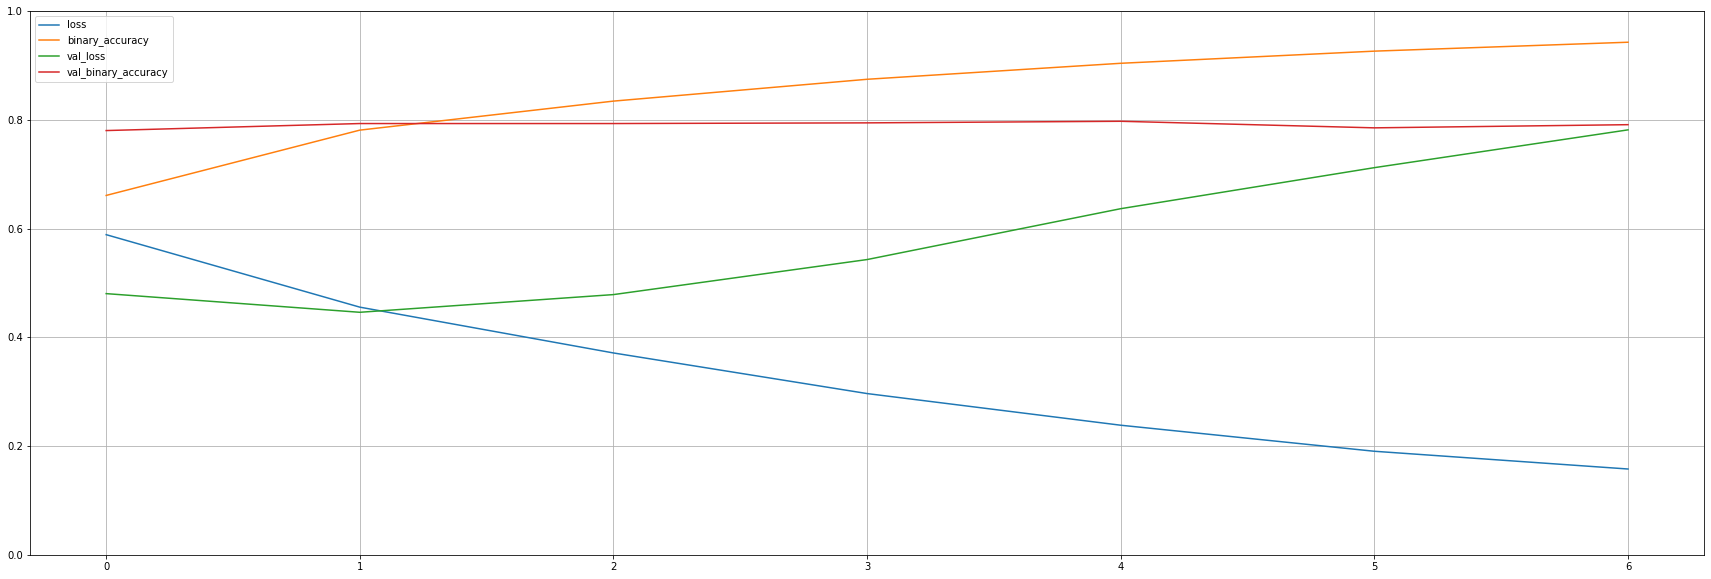

In [27]:
pd.DataFrame(history.history).plot(figsize=(30,10))
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()